In [129]:
# Run the capstone_venv so necessary packages are available.
# Import section.

import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm

In [130]:
# Downloaded capstone project data from Kaggle:
# https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri/download?datasetVersionNumber=2

# Unzipped the archive into a directory on my local machine.
my_data_path = "/Users/sh/Documents/School/UCSD Extension /Machine Learning and AI/Capstone/Project Files/Data/archive/"
training_path = my_data_path + "Training/"
testing_path = my_data_path + "Testing/"

In [131]:
# Check the training file counts to see if they match the file counts provided in the documentation for the data.

training_glioma_count = len(os.listdir(training_path+"glioma_tumor/"))
training_meningioma_count = len(os.listdir(training_path+"meningioma_tumor/"))
training_pituitary_count = len(os.listdir(training_path+"pituitary_tumor/"))
training_no_count = len(os.listdir(training_path+"no_tumor/"))

print("Number of training files for glioma tumors:", training_glioma_count)
print("Number of training files for meningioma tumors:", training_meningioma_count)
print("Number of training files for pituitary tumors:", training_pituitary_count)
print("Number of training files for no tumors:", training_no_count)


Number of training files for glioma tumors: 826
Number of training files for meningioma tumors: 822
Number of training files for pituitary tumors: 827
Number of training files for no tumors: 395


In [132]:
# Note that the number of training files for the no tumors images is roughly half of the number of training images for
# the other tumor classes. This imbalance is addressed further down in the notebook.


In [133]:
# Check the testing file counts to see if they match the file counts provided in the documentation for the data.

testing_glioma_count = len(os.listdir(testing_path+"glioma_tumor/"))
testing_meningioma_count = len(os.listdir(testing_path+"meningioma_tumor/"))
testing_pituitary_count = len(os.listdir(testing_path+"pituitary_tumor/"))
testing_no_count = len(os.listdir(testing_path+"no_tumor/"))

print("Number of testing files for glioma tumors:", testing_glioma_count)
print("Number of testing files for meningioma tumors:", testing_meningioma_count)
print("Number of testing files for pituitary tumors:", testing_pituitary_count)
print("Number of testing files for no tumors:", testing_no_count)

Number of testing files for glioma tumors: 100
Number of testing files for meningioma tumors: 115
Number of testing files for pituitary tumors: 74
Number of testing files for no tumors: 105


In [134]:
# File counts for both training and testing data match the documentation.

# Load the data and begin the exploration.

# Per the source data, images are 512x512.

labels = ["glioma_tumor", "meningioma_tumor","pituitary_tumor", "no_tumor"]

# for i in tqdm(range(20)):

# Load the training data.
X_train = []
y_train = []

# Resize images to a smaller size to simplify processing.
#image_size = 512
image_size = 256

for label in labels:
    folder_path = os.path.join(training_path, label)
    print("Training image folder path:", folder_path)

    # Use tqdm to show progress bar.
    for image_filename in tqdm(os.listdir(folder_path)):
       image = cv2.imread(os.path.join(folder_path, image_filename))
       image = cv2.resize(image,(image_size, image_size))
       X_train.append(image)
       y_train.append(label)


Training image folder path: /Users/sh/Documents/School/UCSD Extension /Machine Learning and AI/Capstone/Project Files/Data/archive/Training/glioma_tumor


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 826/826 [00:00<00:00, 1287.99it/s]


Training image folder path: /Users/sh/Documents/School/UCSD Extension /Machine Learning and AI/Capstone/Project Files/Data/archive/Training/meningioma_tumor


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 822/822 [00:00<00:00, 1412.81it/s]


Training image folder path: /Users/sh/Documents/School/UCSD Extension /Machine Learning and AI/Capstone/Project Files/Data/archive/Training/pituitary_tumor


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 827/827 [00:00<00:00, 1212.77it/s]


Training image folder path: /Users/sh/Documents/School/UCSD Extension /Machine Learning and AI/Capstone/Project Files/Data/archive/Training/no_tumor


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 395/395 [00:00<00:00, 1342.92it/s]


In [135]:
# Load the test data.

# Can load into a separate structure, or 
# load into the same structure as the training data and use train test split later to create validation and test datasets.
# Chose to load into the same structure.

# Load the testing data.

for label in labels:
    folder_path = os.path.join(testing_path, label)
    print("Testing image folder path:", folder_path)
    for image_filename in tqdm(os.listdir(folder_path)):
       image = cv2.imread(os.path.join(folder_path, image_filename))
       image = cv2.resize(image,(image_size, image_size))
       X_train.append(image)
       y_train.append(label)


Testing image folder path: /Users/sh/Documents/School/UCSD Extension /Machine Learning and AI/Capstone/Project Files/Data/archive/Testing/glioma_tumor


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1216.54it/s]


Testing image folder path: /Users/sh/Documents/School/UCSD Extension /Machine Learning and AI/Capstone/Project Files/Data/archive/Testing/meningioma_tumor


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [00:00<00:00, 1592.86it/s]


Testing image folder path: /Users/sh/Documents/School/UCSD Extension /Machine Learning and AI/Capstone/Project Files/Data/archive/Testing/pituitary_tumor


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 74/74 [00:00<00:00, 621.20it/s]


Testing image folder path: /Users/sh/Documents/School/UCSD Extension /Machine Learning and AI/Capstone/Project Files/Data/archive/Testing/no_tumor


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 105/105 [00:00<00:00, 2248.06it/s]


In [136]:
# Convert to Numpy arrays for easier manipulation and display the shape of the data.
X_array = np.array(X_train)
y_array = np.array(y_train)

print("X array shape:", X_array.shape)
print("Y array shape:", y_array.shape, y_array.dtype)

X array shape: (3264, 256, 256, 3)
Y array shape: (3264,) <U16


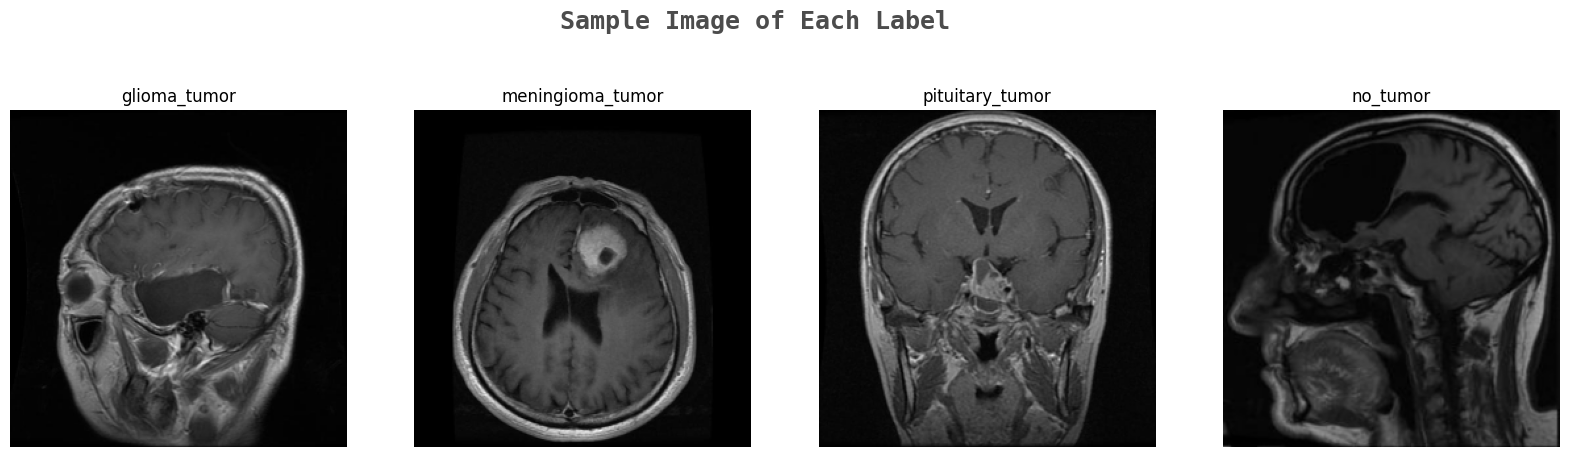

In [137]:
# Display a sample image of each tumor class (label).

plot_counter=0
# Create a subplot with one row and four columns (one column for each class).
fig, ax = plt.subplots(1,4,figsize=(20,20))
# Set the text and position for the subplot figure.
fig.text(s="Sample Image of Each Label",size=18,fontweight="bold",
             fontname="monospace",color="#1F1F1F",y=0.62,x=0.4,alpha=0.8)

# For each tumor class (label):
for label in labels:
    image_counter=0
    while True :
        # Find a matching label in the training data.
        if y_array[image_counter]==label:
            # Create a plot of the image, using the image from the X data and the associated label from the y data.
            ax[plot_counter].imshow(X_array[image_counter])
            ax[plot_counter].set_title(y_array[image_counter])
            ax[plot_counter].axis('off')
            plot_counter+=1
            break
        image_counter+=1

Text(0.5, 0, 'Training Image Count by Class')

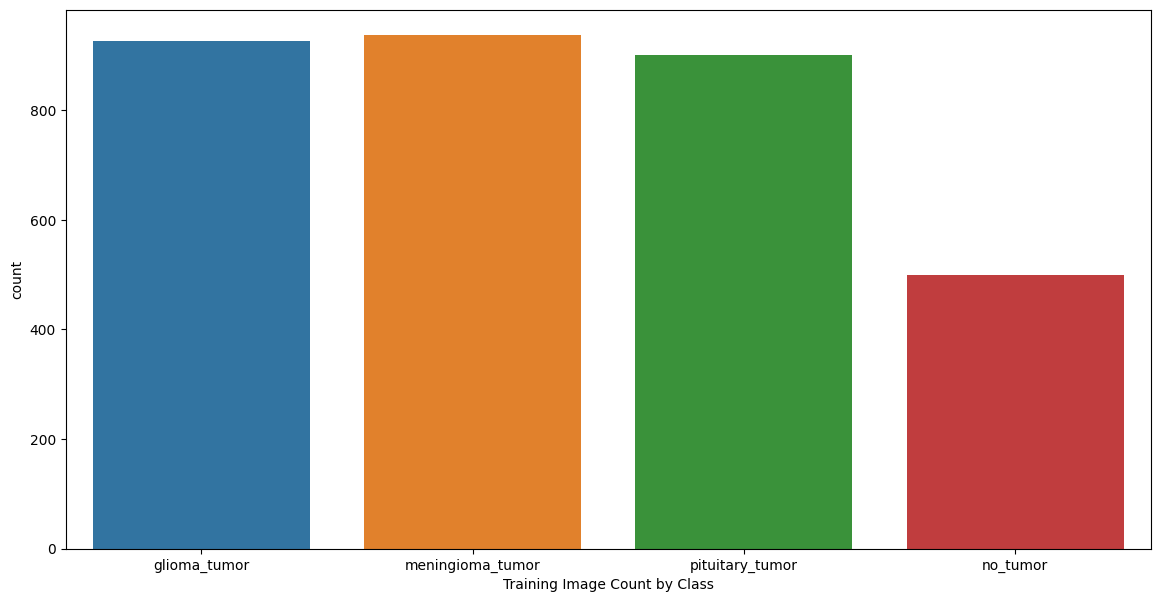

In [138]:
# Create chart of label counts.

# Set figure size and title.
plt.figure(figsize = (14,7));
figure_title = "Training Image Count by Class"
# Create a countplot using seaborn.
sns.countplot(x=y_array, hue=y_array);
plt.xlabel(figure_title)


In [139]:
# Augment the no tumor training class images to addresss the class imbalance.
# Augment pictures (rotate, shift, flip).

# Create a separate array that contains the no tumor images.
no_tumor_array = X_array[y_array == "no_tumor"]
print("no_tumor_array shape:", no_tumor_array.shape)
# The array contains 500 images.

# Directory path to save augmented images to.
augmented_img_path = "/Users/sh/Documents/School/UCSD Extension /Machine Learning and AI/Capstone/Project Files/Data/augmented"

# Create and ImageDataGenerator to augment the images (rotate 25 degrees, shift width and height 10%, flip horizontal).
image_augmenter = ImageDataGenerator(rotation_range=25, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)

# Apply the augmentation to the no tumor data.
image_augmenter.fit(no_tumor_array)

# Create augmented images and labels.
# Chose to generate 320 images (256+64 = 320).
image_counter = 0
for batch in image_augmenter.flow(x=no_tumor_array, batch_size=1, save_to_dir=augmented_img_path, save_prefix='no_tumor', save_format='jpeg'):
    image_counter += 1    
# Stop after generating 320 images
    if image_counter == 320:
        break




no_tumor_array shape: (500, 256, 256, 3)


In [140]:
# Create an array for the labels:
no_tumor_labels_array = np.full((320,), "no_tumor", dtype= "<U16")

# Create an empty array for the augmented images
X_augmented = []


# oslsitdir below picking up hidden files? Yes! Use glob instead.

# Read in the augmented images.
# Use tqdm to show progress bar.
augmented_images = glob.glob(augmented_img_path + "/*.jpeg")
#for image_filename in tqdm(os.listdir(augmented_img_path)):
for image_filename in augmented_images:  
    image = cv2.imread(os.path.join(augmented_img_path, image_filename))
    X_augmented.append(image)

print("X_augmented length:", len(X_augmented))

X_augmented length: 320


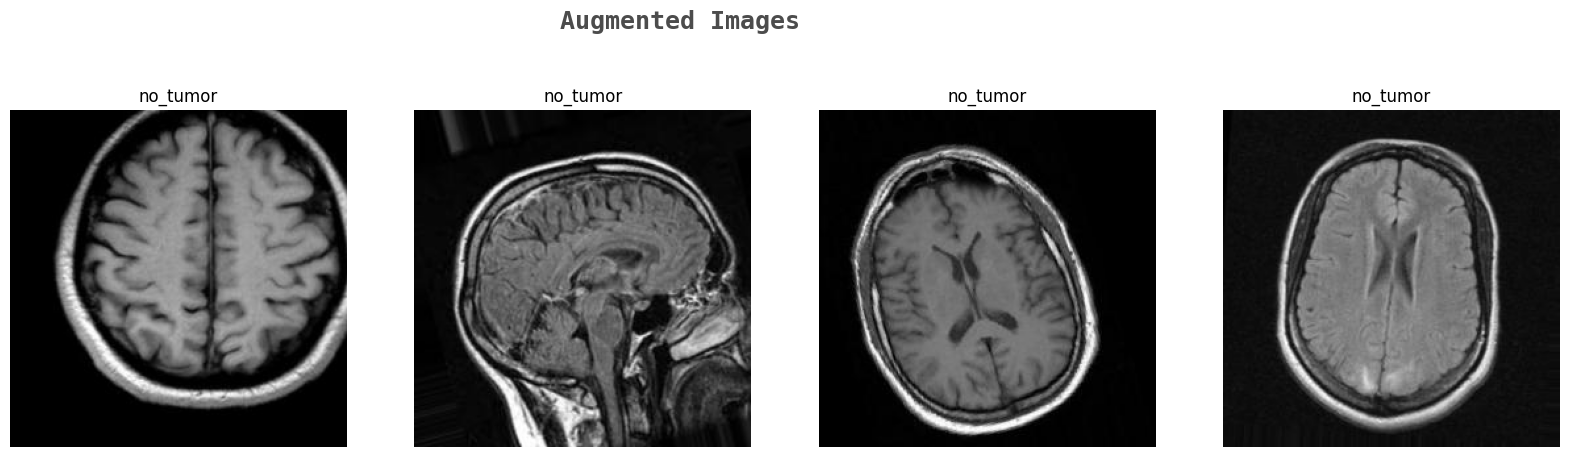

In [141]:
# Display a few augmented images.
# Could also have displayed some images while generating images in the above step, but kept separate so easier to read the code.

# Create a subplot with one row and four columns.
fig, ax = plt.subplots(1,4,figsize=(20,20))
# Set the text and position for the subplot figure.
fig.text(s="Augmented Images",size=18,fontweight="bold",
             fontname="monospace",color="#1F1F1F",y=0.62,x=0.4,alpha=0.8)

# Generate 4 random numbers that fall within (0, 320).
image_counter=0
random.seed(123)
# Note setting the seed just means that you always show the image from the same index in the X_augmented list.
# Everytime you run the code that actual tranformation applied to generate each image will be different.
random_list = random.sample(range(0, 320), 4)

# Plot 4 randomly selected images
while image_counter < len(random_list):
    # Create a plot of the image, using the image from the X augmented data and the associated label from the y training data.
    ax[image_counter].imshow(X_augmented[random_list[image_counter]])
    ax[image_counter].set_title(no_tumor_labels_array[random_list[image_counter]])
    ax[image_counter].axis('off')

    image_counter+=1



In [142]:
# Add the augmented no tumor images and labels to the X and y data.
print("X_augmented length:", len(X_augmented))
print("np.array(X_augmented)", np.array(X_augmented).shape)
print("X_array", type(X_array), X_array.shape)


X_array = np.concatenate((X_array, np.array(X_augmented)), axis=0)

print("y_array", type(y_array), y_array.shape)
y_array = np.append(y_array, no_tumor_labels_array) 

print("X_array", type(X_array), X_array.shape)
print("y_array", type(y_array), y_array.shape)

X_augmented length: 320
np.array(X_augmented) (320, 256, 256, 3)
X_array <class 'numpy.ndarray'> (3264, 256, 256, 3)
y_array <class 'numpy.ndarray'> (3264,)
X_array <class 'numpy.ndarray'> (3584, 256, 256, 3)
y_array <class 'numpy.ndarray'> (3584,)


In [143]:
# One hot encode labels.


label_encoder = LabelEncoder()
y_array = label_encoder.fit_transform(y_array)

# One hot encode
y_array_encoded = to_categorical(y_array)
#y_array_encoded = to_categorical(y_array, num_classes=4)

print("y_array_encoded shape:", y_array_encoded.shape)

y_array_encoded shape: (3584, 4)


In [144]:
# Set random seed.
seed =123

# Split into train and test data.
# shuffle=True by default but included it in the function call for clarity.
# Use stratify to make sure the same proportion of each label exists in the training and the test data.
X_train, X_test, y_train, y_test = train_test_split(X_array, y_array_encoded, shuffle=True, stratify=y_array_encoded, random_state=seed)

# Split the data into training and validation sets.
# Chose to use only 10% of the training data for validation due to the number of images available.
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle=True, stratify=y_train, random_state=seed)


In [145]:
# Look at the shapes of everything:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)


X_train shape: (2419, 256, 256, 3)
y_train shape: (2419, 4)
X_test shape: (896, 256, 256, 3)
y_test shape: (896, 4)
X_val shape: (269, 256, 256, 3)
y_val shape: (269, 4)


In [146]:
# Create sequential CNN model in Keras to predict tumor classes in the brain training data.

# Import statements - move to top.
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPool2D

#from keras.layers import Dense, Dropout, Flatten
#from keras.layers import Conv2D, MaxPooling2D, Conv3D, BatchNormalization, Activation

# Define the Keras model
model1_cnn = Sequential()


# How many more convolutional layers to add? Based on metrics (ex. score/accuracy)?


# Chose 3,3 kernel size for first convolutional to try to capture more detail from each image.
model1_cnn.add(Conv2D(kernel_size=(3,3) ,filters=32, activation='relu', padding='same', input_shape=(256,256,3)))
model1_cnn.add(MaxPool2D(pool_size=(2,2)))

# Add second convolutional and max pooling layers.
# Chose to increase the numbe rof filters in the convolutional layer per guidance at https://datascience.stackexchange.com/questions/55545/in-cnn-why-do-we-increase-the-number-of-filters-in-deeper-convolution-layers-fo#:~:text=The%20reason%20why%20the%20number,%22dirty%22%20raw%20pixel%20data.
model1_cnn.add(Conv2D(kernel_size=(3,3) ,filters=64, activation='relu', padding='same'))
model1_cnn.add(MaxPool2D(pool_size=(2,2)))

# Flatten into 1D tensor.
model1_cnn.add(Flatten())
# Add a dense layer. Relu trains fast and is a good starting activation function.
model1_cnn.add(Dense(128, activation='relu'))
# Add a dropout layer to prevent overfitting. Set dropout rate to 0.5.
model1_cnn.add(Dropout(rate=0.5))
# Add a dense layer to get ouput. Chose softmax activation since this is a multiclassification problem.
model1_cnn.add(Dense(4, activation='softmax'))

# Summarize the model.
model1_cnn.summary()

# Compile the model.
model1_cnn.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Use different optimizer (ex. sge) instead of adam?


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 128, 128, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 64, 64, 64)        0         
 ng2D)                                                           
                                                                 
 flatten_6 (Flatten)         (None, 262144)            0         
                                                                 
 dense_8 (Dense)             (None, 128)              

In [147]:
# Train the model

# model1_cnn.fit(x=X_train, y=y_train , epochs=20, verbose=2)
model1_cnn.fit(x=X_train, y=y_train , validation_data=(X_val, y_val), epochs=20, verbose=2)


Epoch 1/20
76/76 - 17s - loss: 59.6004 - accuracy: 0.5349 - val_loss: 0.8395 - val_accuracy: 0.7472 - 17s/epoch - 225ms/step
Epoch 2/20
76/76 - 17s - loss: 0.7320 - accuracy: 0.7573 - val_loss: 0.7113 - val_accuracy: 0.7770 - 17s/epoch - 221ms/step
Epoch 3/20
76/76 - 17s - loss: 0.4887 - accuracy: 0.8326 - val_loss: 0.6265 - val_accuracy: 0.8699 - 17s/epoch - 220ms/step
Epoch 4/20
76/76 - 17s - loss: 0.3235 - accuracy: 0.8946 - val_loss: 0.5306 - val_accuracy: 0.8439 - 17s/epoch - 222ms/step
Epoch 5/20
76/76 - 17s - loss: 0.2288 - accuracy: 0.9351 - val_loss: 0.5671 - val_accuracy: 0.8625 - 17s/epoch - 222ms/step
Epoch 6/20
76/76 - 17s - loss: 0.2147 - accuracy: 0.9425 - val_loss: 0.5241 - val_accuracy: 0.8736 - 17s/epoch - 221ms/step
Epoch 7/20
76/76 - 17s - loss: 0.1634 - accuracy: 0.9512 - val_loss: 0.6229 - val_accuracy: 0.8550 - 17s/epoch - 222ms/step
Epoch 8/20
76/76 - 17s - loss: 0.1536 - accuracy: 0.9611 - val_loss: 0.7041 - val_accuracy: 0.8810 - 17s/epoch - 223ms/step
Epoch 9

In [148]:
# Make predictions on test data
y_predicted = model1_cnn.predict(X_test)

28/28 [==============================] - 2s 55ms/step


In [149]:
# Confusion matrix

# Save a copy of y_test beofre calling argmax (for development purposes).
#y_test_copy = y_test

# Why need argmax?
# Taken from https://stackoverflow.com/questions/48987959/classification-metrics-cant-handle-a-mix-of-continuous-multioutput-and-multi-la
y_test=np.argmax(y_test, axis=1)
y_predicted=np.argmax(y_predicted, axis=1)

cnn_confusion_matrix = confusion_matrix(y_test, y_predicted)

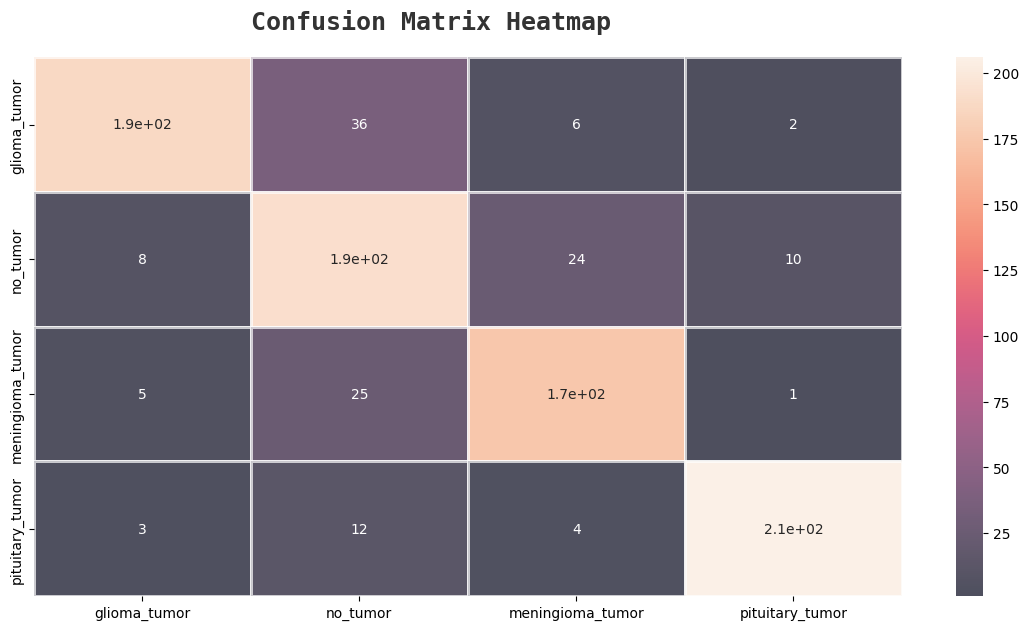

In [150]:
# Plot the confusion matrix as a heatmap.

# Create a 1 x 1 subplot, size (14,7)
fig,ax=plt.subplots(1,1,figsize=(14,7))

# Create labels for the axes.
axis_labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']

# Generate a heatmap for the confusion matrix using the labels for each axis, and write the data in each cell.
sns.heatmap(cnn_confusion_matrix,ax=ax,xticklabels=axis_labels,yticklabels=axis_labels,annot=True, alpha=0.7,linewidths=2)

# Create text for the heatmap.
fig.text(s="Confusion Matrix Heatmap",size=18,fontweight="bold", fontname="monospace",y=0.92,x=0.28,alpha=0.8)

# Show the plot of the confusion matrix.
plt.show()

In [151]:
# Classification report.

# 0 - Glioma Tumor
# 1 - No Tumor
# 2 - Meningioma Tumor
# 3 - Pituitary Tumor

cnn_classification_report = classification_report(y_test,y_predicted)
print(cnn_classification_report)

              precision    recall  f1-score   support

           0       0.92      0.81      0.86       232
           1       0.72      0.82      0.77       234
           2       0.84      0.85      0.84       205
           3       0.94      0.92      0.93       225

    accuracy                           0.85       896
   macro avg       0.86      0.85      0.85       896
weighted avg       0.86      0.85      0.85       896



In [154]:
# Pituitary is higher in precision and recall, possibly because pituitary tumors are limited to one general area of the brain.
# No tumor has the lowest precision, maybe has something to do with training on augmented data?

In [155]:
# Get score?
#score = model1_cnn.evaluate(X_test, y_test)
#print(score)